In [3]:
import pandas as pd
import numpy as np
import gzip

In [21]:
beers = pd.read_csv('data/beers.csv')
breweries = pd.read_csv('data/breweries.csv')
users = pd.read_csv('data/users.csv')

In [22]:
import re
import nltk
from nltk.corpus import stopwords
from nltk import pos_tag
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk import pos_tag
from multiprocessing import Pool
from tqdm import tqdm

# Download necessary NLTK data
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
nltk.download('vader_lexicon')

[nltk_data] Downloading package punkt to /Users/guillen/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/guillen/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/guillen/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/guillen/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/guillen/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

### Extracting and processing the reviews

In [25]:
from process_reviews import get_tokens

# Processes the tokens, using stopwords, removing punctuation, lemmatization and only keeping nouns and adjectives
all_tokens = get_tokens('data/reviews.txt.gz', review_limit=1000000)

### Vectorizing with TF-IDF and getting the best features out

In [27]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Create a TF-IDF Vectorizer
vectorizer = TfidfVectorizer(max_features=1000, min_df = 0.005)  # Limit to top 1000 terms, showing terms that appears in at least 0.5% of the docs
X = vectorizer.fit_transform([" ".join(token) for token in all_tokens])  # Transform reviews to TF-IDF matrix

In [28]:
top_feats = set(vectorizer.get_feature_names_out())
print('Some Feature Names : ', vectorizer.get_feature_names_out()[::100])

Some Feature Names :  ['able' 'bubble' 'day' 'finish' 'ice' 'middle' 'place' 'semi' 'sweetish'
 'wet']


### From the top 1000 features of our TF-IDF matrix, we manually select the ones that have smthg to do with beer

In [79]:
beer_lexicon = {
    'beer', 'ale', 'lager', 'stout', 'porter', 'pilsner', 'ipa', 'brewer', 
 'brewery', 'brewing', 'draft', 'cask', 'bottle', 'glass', 'pour', 'tap','head', 'foam', 
    'frothy', 'bubbly', 'carbonated', 'flat', 'clarity','hazy', 'opaque', 'cloudy', 'clear', 'golden', 'amber', 'brown', 'dark', 
 'black', 'mahogany', 'ruby', 'white', 'pale', 'yellow', 'beige', 'red', 
 'floral', 'herbal', 'earthy', 'spicy', 'citrusy', 'fruity', 'sweet', 
 'sour', 'bitter', 'bitterness', 'smooth', 'rich', 'dry', 'crisp', 'creamy', 
 'sticky', 'tart', 'tangy', 'sweetness', 'malty', 'hoppy', 'aromatic', 
 'aroma', 'aftertaste', 'subtle', 'intense',
'barley', 'malt', 'malty', 'grain', 'yeast', 'hops', 'hop', 'water', 
 'spices', 'vanilla', 'chocolate', 'caramel', 'toffee', 'coffee', 'cocoa', 
 'citrus', 'orange', 'lemon', 'grapefruit', 'pine', 'oak', 'nutty', 'raisin', 
 'plum', 'cherry', 'maple', 'banana', 'berry', 'ginger','session', 'sessionable', 'pint', 'ounce', 'ounce', 'snifter', 'chalice', 
 'pub', 'bar', 'draught', 'taste', 'drink', 'drinker', 'sip', 'gulp', 
 'quaffable','balanced', 'strong', 'bold', 'weak', 'delicate', 'refreshing', 'complex', 
 'light', 'heavy', 'moderate', 'intense', 'robust', 'unique', 'classic', 
 'distinctive', 'remarkable', 'awesome', 'excellent', 'superb', 'good', 
 'decent', 'ok', 'average', 'bad', 'boring', 'cheap', 'quality','balanced', 'strong', 'bold', 'weak', 'delicate', 'refreshing', 'complex', 
 'light', 'heavy', 'moderate', 'intense', 'robust', 'unique', 'classic', 
 'distinctive', 'remarkable', 'awesome', 'excellent', 'superb', 'good', 
 'decent', 'ok', 'average', 'bad', 'boring', 'cheap', 'aged', 'vintage', 'cellar', 'oak', 'barrel', 'reserve', 'craft', 'microbrewery', 'homebrew', 'regional', 'seasonal', 'festive', 
 'holiday', 'celebration', 'festival', 'special'}

### We filter the beer-related tokens, getting rid of the rest
Every review is left with beer-related tokens whose vocabulary is the beer_lexicon

In [77]:
all_tokens_beer = [[word for word in sentence if word in beer_lexicon] for sentence in all_tokens]

### We train our Model (using Word2Vec)

In [35]:
from gensim.models import Word2Vec

model = Word2Vec(sentences=all_tokens_beer, vector_size=100, window=3, min_count=1, workers=4)

Checking the understanding of our model with beer-related content : 

In [37]:
print('Tokens most similar to IPA : \n', model.wv.most_similar('ipa', topn=5))

Tokens most similar to IPA : 
 [('citrusy', 0.7408379316329956), ('refreshing', 0.7262238264083862), ('hoppy', 0.7247021794319153), ('citrus', 0.6414749622344971), ('grapefruit', 0.6351175904273987)]


In [96]:
print('Tokens (stout and chocolate) - (citrus and ipa) gives us : \n', 
      model.wv.most_similar(positive=['stout', 'chocolate'], negative=['citrus', 'ipa'], topn=3))

Tokens (stout and chocolate) - (citrus and ipa) gives us : 
 [('coffee', 0.7064121961593628), ('dark', 0.6670213937759399), ('black', 0.6415765881538391)]


### Recreating a Vectorizer (TF-IDF) focusing only on the beer lexicon

With the goal of simplifying our model and reducing the noise, new TF-IDF matrix with vocabulary being beer_lexicon

In [81]:
vectorizer_beer = TfidfVectorizer(vocabulary=beer_lexicon)

In [83]:
X_beer = vectorizer_beer.fit_transform([" ".join(token) for token in all_tokens_beer])

### LDA

In [43]:
from sklearn.decomposition import LatentDirichletAllocation

lda = LatentDirichletAllocation(n_components=5, random_state=42)  # 5 topics
lda.fit(X_beer)

LatentDirichletAllocation(n_components=5, random_state=42)

In [98]:
# Display top words for each topic
words = vectorizer_beer.get_feature_names_out()
for i, topic in enumerate(lda.components_):
    print(f'topic length : {topic.shape}')
    print(f"Topic {i}: {[words[j] for j in topic.argsort()[-10::]]}")

topic length : (149,)
Topic 0: ['caramel', 'head', 'malty', 'hop', 'sweet', 'malt', 'good', 'taste', 'ale', 'beer']
topic length : (149,)
Topic 1: ['head', 'creamy', 'taste', 'malt', 'coffee', 'black', 'beer', 'dark', 'stout', 'chocolate']
topic length : (149,)
Topic 2: ['golden', 'head', 'taste', 'ipa', 'white', 'citrus', 'light', 'malt', 'beer', 'hop']
topic length : (149,)
Topic 3: ['head', 'light', 'dark', 'malt', 'sweet', 'vanilla', 'toffee', 'oak', 'caramel', 'beer']
topic length : (149,)
Topic 4: ['head', 'banana', 'malt', 'taste', 'porter', 'beer', 'black', 'dark', 'coffee', 'chocolate']


### Extracting the top features

These features will be added to each beer by using its reviews to enrich its descriptions, ultimately enhancing the performance of our recommender system.

In [68]:
features_score = np.sum(X_beer, axis=0).A1

In [89]:
top_indices = np.argsort(features_score)[::-1][:50]  # Sort in descending order
top_50_features = np.array(vectorizer_beer.get_feature_names_out())[top_indices]

In [91]:
top_50_features

array(['beer', 'malt', 'taste', 'hop', 'head', 'dark', 'good', 'sweet',
       'chocolate', 'light', 'aroma', 'bottle', 'ale', 'caramel', 'glass',
       'bitter', 'brown', 'coffee', 'black', 'white', 'bitterness',
       'stout', 'creamy', 'malty', 'smooth', 'dry', 'sweetness', 'clear',
       'pint', 'strong', 'fruity', 'rich', 'toffee', 'aftertaste',
       'decent', 'citrus', 'orange', 'earthy', 'vanilla', 'floral',
       'golden', 'pale', 'amber', 'heavy', 'hoppy', 'bad', 'drink', 'ipa',
       'complex', 'red'], dtype=object)

### Sentiment and Aspect-Based Analysis

In [392]:
from nltk.sentiment import SentimentIntensityAnalyzer

analyzer = SentimentIntensityAnalyzer()
for review in all_reviews[:5]:
    sentiment = analyzer.polarity_scores(review)
    print(f"Review: {review}")
    print(f"Sentiment: {sentiment}")


Review: From a bottle, pours a piss yellow color with a fizzy white head.  This is carbonated similar to soda.The nose is basic.. malt, corn, a little floral, some earthy straw.  The flavor is boring, not offensive, just boring.  Tastes a little like corn and grain.  Hard to write a review on something so simple.Its ok, could be way worse.
Sentiment: {'neg': 0.184, 'neu': 0.704, 'pos': 0.112, 'compound': -0.5625}
Review: Pours pale copper with a thin head that quickly goes. Caramel, golden syrup nose. Taste is big toasty, grassy hops backed by dark fruit, candy corn and brack malts. Clingy. Dries out at the end with more hops. Brave, more going on that usual for this type.
Sentiment: {'neg': 0.0, 'neu': 0.902, 'pos': 0.098, 'compound': 0.5829}
Review: ml Bottle bought from The Vintage, Antrim...Poured a golden yellow / orange colour... White head poured quite thick and foamy and faded to thin layer...Aroma - Fruity (burnt orange, some apple hints), light maltiness, spicy hops, vanilla,

In [97]:
from sklearn.metrics.pairwise import cosine_similarity

cosine_sim = cosine_similarity(X)

In [107]:
np.fill_diagonal(cosine_sim, 0)  # Ignore self-similarity
most_similar = np.unravel_index(np.argmax(cosine_sim), cosine_sim.shape)
cosine_sim[0]

array([0.        , 0.0542427 , 0.07491401, ..., 0.19301125, 0.06326846,
       0.01787906])

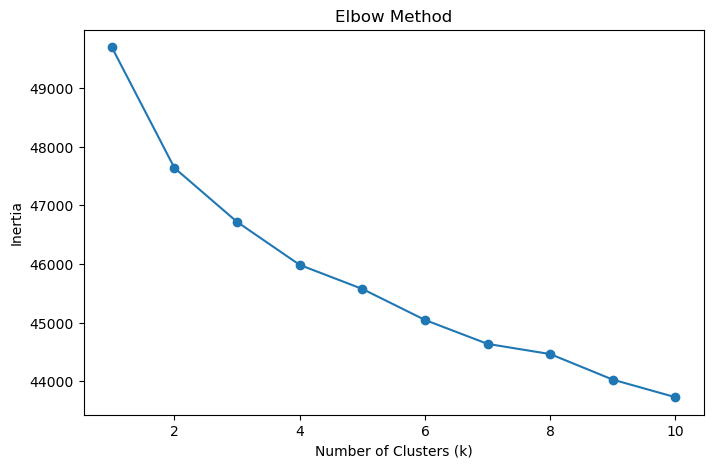

In [319]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Example: Find the optimal k using the Elbow Method
inertia = []
K = range(1, 11)  # Test k values from 1 to 10

for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_beer)  # X is your TF-IDF or feature matrix
    inertia.append(kmeans.inertia_)

# Plot the inertia curve
plt.figure(figsize=(8, 5))
plt.plot(K, inertia, marker='o')
plt.title('Elbow Method')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.show()


In [374]:
# Perform K-Means clustering
num_clusters = 7
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
clusters = kmeans.fit_predict(X_beer[::10])

# Assign cluster labels back to the original reviews
clustered_reviews = [{"review": review, "cluster": cluster} for review, cluster in zip(all_tokens_beer, clusters)]

# Print some sample reviews from each cluster
for cluster_id in range(num_clusters):
    print(f"\nCluster {cluster_id}:")
    for item in [r["review"] for r in clustered_reviews if r["cluster"] == cluster_id][:3]:  # Show 3 reviews per cluster
        print(item)



Cluster 0:
['bottle', 'yellow', 'white', 'head', 'malt', 'floral', 'earthy', 'boring', 'taste', 'grain', 'ok']
['ounce', 'bottle', 'pilsner', 'glass', 'creamy', 'head', 'clear', 'dark', 'amber', 'rich', 'brown', 'malty', 'dry', 'malt', 'hop', 'malty', 'brown', 'beer']
['bottle', 'pint', 'beer', 'dark', 'white', 'head', 'aroma', 'sweet', 'toffee', 'bitter', 'tangy', 'sweet', 'caramel', 'light', 'bold', 'aftertaste', 'sweet', 'toffee', 'tangy', 'bad', 'drink']

Cluster 1:
['hazy', 'golden', 'light', 'hop', 'aroma', 'sweetness', 'hoppy', 'floral', 'hop', 'malt', 'good']
['bottle', 'brown', 'clarity', 'frothy', 'head', 'beer', 'malty', 'aroma', 'taste', 'malt', 'taste', 'bottle', 'draft', 'weak', 'decent', 'awesome']
['beer', 'bottle', 'pint', 'beer', 'head', 'head', 'dark', 'brown', 'opaque', 'brown', 'sweet', 'floral', 'beer', 'caramel', 'sweet', 'taste', 'maple', 'caramel', 'hop', 'taste', 'sip', 'malt', 'malt', 'aftertaste', 'bitter', 'beer', 'beer', 'sweet']

Cluster 2:
['pint', 'gla

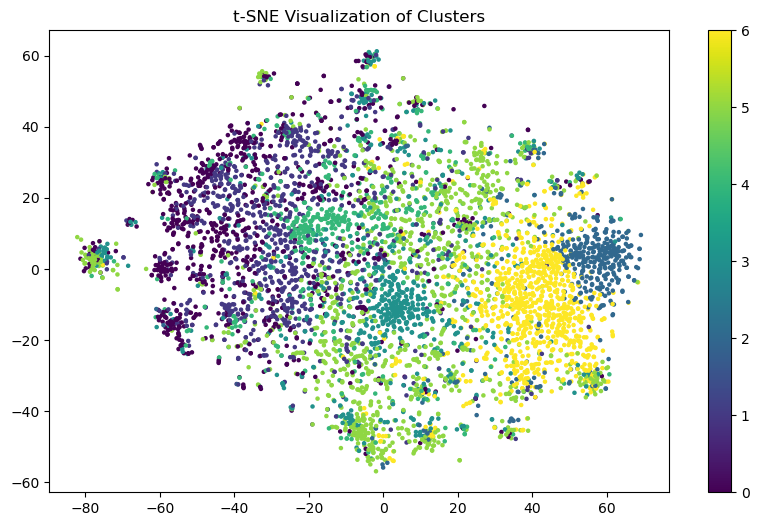

In [376]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# Reduce dimensions for visualization
tsne = TSNE(n_components=2, random_state=42)
reduced_data = tsne.fit_transform(X_beer.toarray()[::10])

# Plot the clusters
plt.figure(figsize=(10, 6))
plt.scatter(reduced_data[:, 0], reduced_data[:, 1], c=clusters, cmap='viridis', s=5)
plt.colorbar()
plt.title("t-SNE Visualization of Clusters")
plt.show()
